In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [148]:
stock_symbols = ['GOOG','MSFT','AMZN','NVDA','AAPL']

In [242]:
# Initialize dictionaries
df_sentiment_scores_dict = {}
df_stock_data_dict = {}
sentiment_scores = {}
stock_data = {}
stock_diff_close_open = {}

start_date = pd.to_datetime('2011-05-02').date()
end_date = pd.to_datetime('2024-03-15').date()

for symbol in stock_symbols:
    # Load sentiment and stock data
    df_sentiment_scores_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stock_news_sentiment_analysis_results_{symbol}.csv')
    df_stock_data_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stocks data/stock_data_{symbol}.csv')

    # Convert date columns to datetime and extract date part only as `datetime.date`
    df_sentiment_scores_dict[symbol]['Date'] = pd.to_datetime(df_sentiment_scores_dict[symbol]['Date'], errors='coerce').dt.date
    df_stock_data_dict[symbol]['Date'] = pd.to_datetime(df_stock_data_dict[symbol]['Date'], errors='coerce').dt.date
    
    # Filter sentiment scores based on date range
    mask_sentiment = (df_sentiment_scores_dict[symbol]['Date'] >= start_date) & (df_sentiment_scores_dict[symbol]['Date'] <= end_date)
    sentiment_filtered = df_sentiment_scores_dict[symbol][mask_sentiment]

    # Filter stock data based on date range and intersecting dates
    stock_dates = df_stock_data_dict[symbol]['Date']
    mask_stock = (stock_dates >= start_date) & (stock_dates <= end_date) & (stock_dates.isin(sentiment_filtered['Date']))
    stock_filtered = df_stock_data_dict[symbol][mask_stock]

    # Align both DataFrames by keeping only common dates
    common_dates = sentiment_filtered['Date'][sentiment_filtered['Date'].isin(stock_filtered['Date'])]
    sentiment_aligned = sentiment_filtered[sentiment_filtered['Date'].isin(common_dates)]
    stock_aligned = stock_filtered[stock_filtered['Date'].isin(common_dates)]

    # Calculate the weighted rolling mean on aligned data for sentiment scores
    sentiment_scores[symbol] = sentiment_aligned['Weighted compound sentiment score']#.rolling(rw).apply(weighted_mean, raw=True)
    
    # Calculate the weighted rolling mean for the difference between 'Close' and 'Open' prices
    stock_diff_close_open[symbol] = (stock_aligned['Close'] - stock_aligned['Open'])#.rolling(rw).apply(weighted_mean, raw=True)



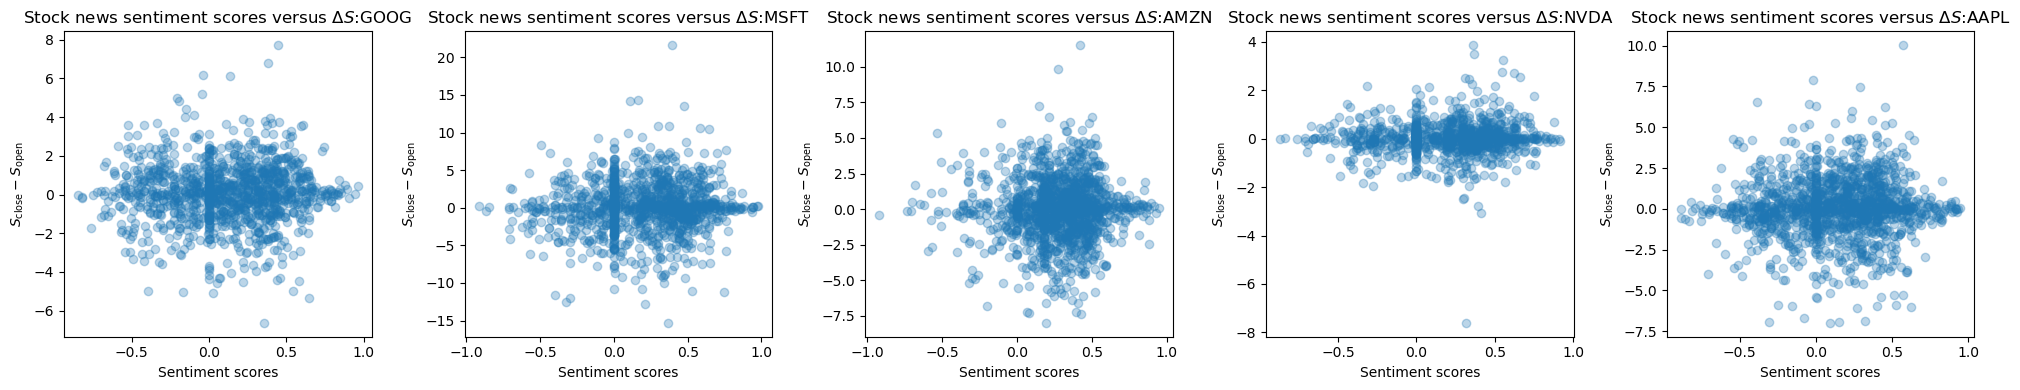

In [243]:
# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Loop through each plot and corresponding axis
for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    axes[i].scatter(sentiment_scores[symbol],stock_diff_close_open[symbol],alpha = .3)
    axes[i].set_title(r"Stock news sentiment scores versus $\Delta S$:" f"{symbol}")
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

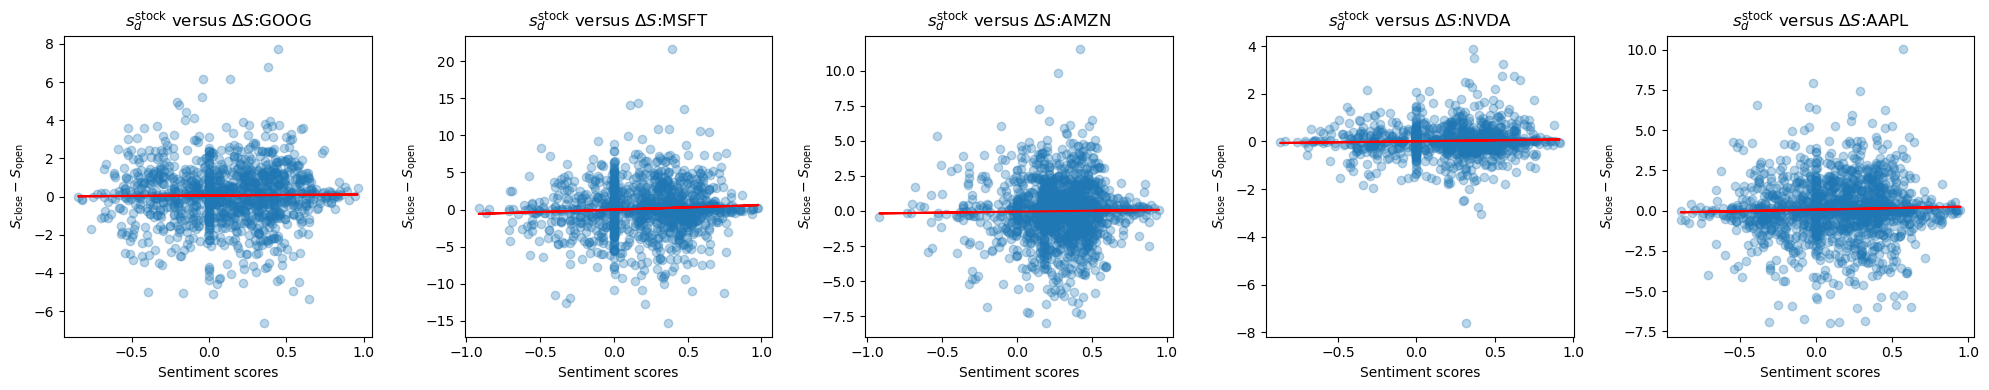

In [244]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Loop through each plot and corresponding axis
model = {}
mses = {}
for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    # Reshape your data if needed
    X = np.array(sentiment_scores[symbol]).reshape(-1, 1)  # Sentiment scores as predictor
    y = np.array(stock_diff_close_open[symbol])

    model[symbol] = LinearRegression().fit(X , y)
    y_pred = model[symbol].predict(X)
    mses[symbol] = mse(y, y_pred)
    
    axes[i].scatter(sentiment_scores[symbol],stock_diff_close_open[symbol],alpha = .3)
    axes[i].plot(sentiment_scores[symbol],y_pred,color = "red")
    
    axes[i].set_title(r"$s^{\text{stock}}_d$ versus $\Delta S$:" f"{symbol}")
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [245]:
for symbol in stock_symbols:
    print([model[symbol].coef_,model[symbol].intercept_])

[array([0.05206937]), np.float64(0.059182877862174424)]
[array([0.62080631]), np.float64(-0.016098949653384764)]
[array([0.13402547]), np.float64(-0.05202832793721683)]
[array([0.08290068]), np.float64(0.008899352266528614)]
[array([0.18837617]), np.float64(0.0620875134032645)]


In [247]:
# Fit via statsmodel 
import statsmodels.api as sm

X_goog = np.array(sentiment_scores['GOOG'])
y_goog = np.array(stock_diff_close_open['GOOG'])

X_with_const = sm.add_constant(X_goog)

model_ols = sm.OLS(y_goog, X_with_const)
results = model_ols.fit()

# Print the summary to see coefficients and other statistics
print(results.summary())

# Get the confidence intervals for the coefficients
confidence_intervals = results.conf_int(alpha=0.05)  # 95% CI by default
print("Confidence intervals:\n", confidence_intervals)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1604
Date:                Mon, 04 Nov 2024   Prob (F-statistic):              0.689
Time:                        03:50:25   Log-Likelihood:                -2229.4
No. Observations:                1202   AIC:                             4463.
Df Residuals:                    1200   BIC:                             4473.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0592      0.047      1.262      0.2

In [20]:
# import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

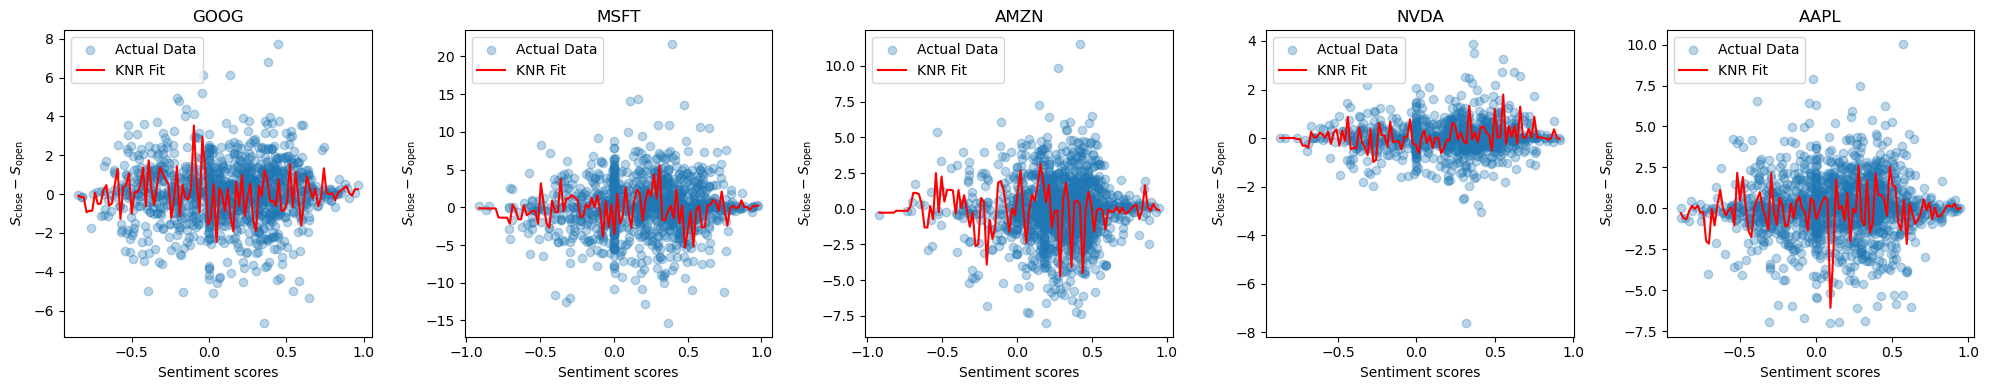

In [248]:
# Loop through each plot and corresponding axis
kNN_model = {}
kNN_mses = {}

# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    
    # Define x and y for actual data points
    x = np.array(sentiment_scores[symbol][6:]).reshape(-1, 1)  # Ensure x is 2D
    y = np.array(stock_diff_close_open[symbol][6:])

    # Fit the model on actual data points
    kNN_model[symbol] = KNeighborsRegressor(2).fit(x, y)
    
    # Predict on the same x values for MSE calculation
    y_pred_for_mse = kNN_model[symbol].predict(x)
    kNN_mses[symbol] = mse(y, y_pred_for_mse)  # MSE on actual data points
    
    # Generate X_fit for smooth prediction curve
    X_fit = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = kNN_model[symbol].predict(X_fit)
    
    # Plot actual data and prediction curve
    axes[i].scatter(x, y, alpha=0.3, label="Actual Data")
    axes[i].plot(X_fit, y_pred, color="red", label="KNR Fit")
    
    # Set title and labels
    axes[i].set_title(symbol)
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
